# Detection Tool for Dyslexia.
## Team:
Kavisha Mathur : PES1UG20CS203
Kaushal Suresh : PES1UG20CS201
Krishna Bajaj : PES1UG20CS217

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import os.path
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# EDA and Pre-processing Data

## EEG Scans

In [4]:
eeg_data=pd.read_csv('Dataset/EEG/EEG_data.csv')
demographic_data=pd.read_csv('Dataset/EEG/demographic_info.csv')

In [5]:
eeg_data.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [6]:
demographic_data.head()

,subject ID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M


We are going to merge the two dataframes.

In [7]:
demographic_data.rename(columns = {'subject ID':'SubjectID'}, inplace = True)
df=eeg_data.merge(demographic_data,how = 'inner',on = 'SubjectID')
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


In [8]:
df.shape

(12811, 18)

In [9]:
df.columns

Index(['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'predefinedlabel', 'user-definedlabeln', ' age', ' ethnicity',
       ' gender'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12811 entries, 0 to 12810
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
 15   age                12811 non-null  int64  
 16   eth

In [11]:
df.describe()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606,25.409960
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861,2.205148
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000,24.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000,24.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000,25.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000,25.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000,31.000000


We'll replace the categorical values with numerical values.

In [12]:
df[' gender']=df[' gender'].replace({'M':1,'F':0})
df[' ethnicity']=df[' ethnicity'].replace({'Han Chinese':0,'Bengali':1,'English':2})

In [13]:
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,0,1
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,0,1
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,0,1
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,0,1
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,0,1


In [14]:
df['predefinedlabel'].unique()

array([0., 1.])

Checking for imbalanced dataset and null values:

In [15]:
df['predefinedlabel'].value_counts()

0.0    6662
1.0    6149
Name: predefinedlabel, dtype: int64

In [16]:
df.isnull().sum()

SubjectID             0
VideoID               0
Attention             0
Mediation             0
Raw                   0
Delta                 0
Theta                 0
Alpha1                0
Alpha2                0
Beta1                 0
Beta2                 0
Gamma1                0
Gamma2                0
predefinedlabel       0
user-definedlabeln    0
 age                  0
 ethnicity            0
 gender               0
dtype: int64

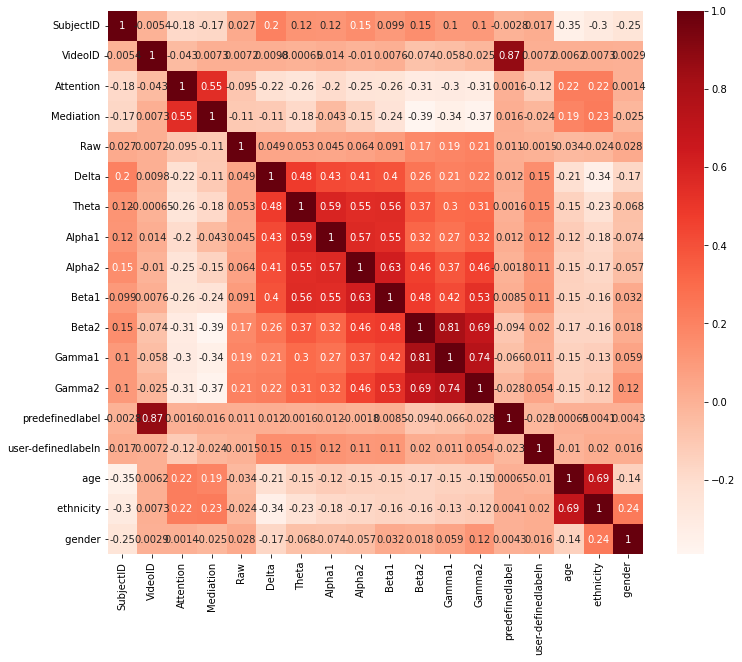

In [18]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Feature Extraction

In [19]:
from sklearn.datasets import fetch_openml
import category_encoders as ce
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif

In [20]:
threshold = 14  # the number of most relevant features
high_score_features = []
mi_score=MIC(df.drop('user-definedlabeln',axis=1),df['user-definedlabeln'])
mi_score=pd.Series(mi_score,index=df.drop('user-definedlabeln',axis=1).columns)
mi_score=(mi_score*100).sort_values(ascending=False)
print(mi_score)

VideoID            6.939966
Alpha2             2.639270
Gamma1             2.520185
Delta              2.438453
Theta              2.107324
Alpha1             2.028399
Beta1              2.002433
Gamma2             1.479049
Attention          1.407462
Beta2              1.368965
Raw                1.086772
SubjectID          0.895167
Mediation          0.779032
 age               0.416051
predefinedlabel    0.309522
 ethnicity         0.289819
 gender            0.000000
dtype: float64


In [21]:
#print(high_score_features)
mi_score.head(14).index

Index(['VideoID', 'Alpha2', 'Gamma1', 'Delta', 'Theta', 'Alpha1', 'Beta1',
       'Gamma2', 'Attention', 'Beta2', 'Raw', 'SubjectID', 'Mediation',
       ' age'],
      dtype='object')

In [22]:
high_score_features=['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1',
       'Beta2', 'Gamma1', 'Gamma2', ' age']
df_top=df[high_score_features]
df_top.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,age
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,25
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,25
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,25
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,25
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,25


## Standardized Tests

In [22]:
data=pd.read_csv('Dataset/Standardized_Test/labeled_dysx.csv')
y=data.Label 
data.head()

X=data.drop(['Label'],axis=1) 
X.head()

,Language_vocab,Memory,Speed,Visual_discrimination,Audio_Discrimination,Survey_Score
0,0.5,0.6,0.5,0.8,0.6,0.7
1,0.6,0.7,0.8,0.9,0.5,0.8
2,0.6,0.4,0.3,0.3,0.4,0.6
3,0.3,0.5,0.2,0.1,0.3,0.5
4,0.7,0.6,0.7,0.8,0.9,0.5


In [23]:
data.dtypes

Language_vocab           float64
Memory                   float64
Speed                    float64
Visual_discrimination    float64
Audio_Discrimination     float64
Survey_Score             float64
Label                      int64
dtype: object

In [24]:
data.shape

(500, 7)

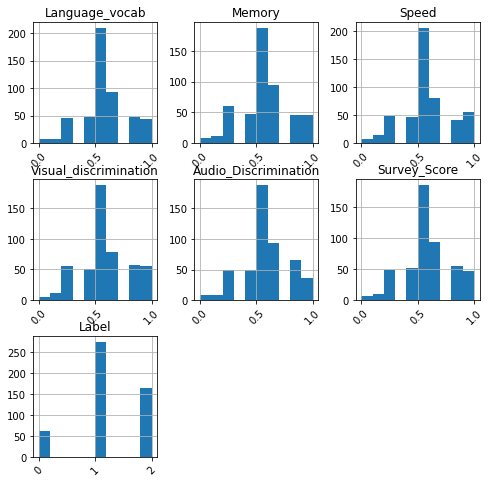

In [25]:
data.hist(figsize=(8,8), xrot=45)
plt.show()

In [26]:
data.describe()

,Language_vocab,Memory,Speed,Visual_discrimination,Audio_Discrimination,Survey_Score,Label
count,500.00000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,0.57800,0.572000,0.576800,0.58260,0.580200,0.581000,1.206000
std,0.20019,0.212382,0.215487,0.21719,0.202163,0.210684,0.642175
min,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.50000,0.400000,0.500000,0.50000,0.500000,0.500000,1.000000
50%,0.60000,0.600000,0.600000,0.60000,0.600000,0.600000,1.000000
75%,0.70000,0.700000,0.700000,0.70000,0.700000,0.700000,2.000000
max,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,2.000000


In [27]:
for col in data.select_dtypes(include='object'):
    if data[col].nunique() <= 22:
        sns.countplot(y=col, data=data)
        plt.show()

<AxesSubplot:>

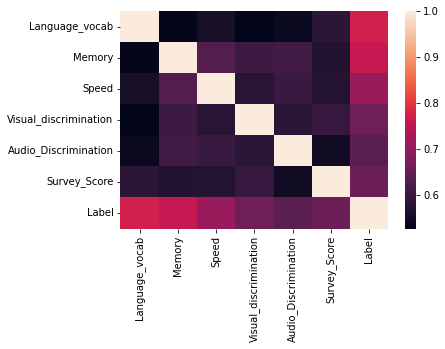

In [28]:
corr=data.corr()
sns.heatmap(corr)

Text(0.5, 1.0, 'Label')

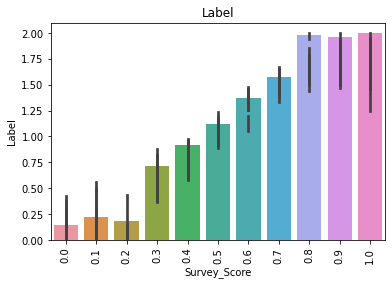

In [29]:
sns.barplot(x='Language_vocab',y='Label',data=data)
plt.xlabel('Language_vocab')
plt.xticks(rotation=90)
plt.title('Label')

sns.barplot(x='Speed',y='Label',data=data)
plt.xlabel('Speed')
plt.xticks(rotation=90)
plt.title('Label')

sns.barplot(x='Visual_discrimination',y='Label',data=data)
plt.xlabel('Visual_discrimination')
plt.xticks(rotation=90)
plt.title('Label')

sns.barplot(x='Audio_Discrimination',y='Label',data=data)
plt.xlabel('Audio_Discrimination')
plt.xticks(rotation=90)
plt.title('Label')

sns.barplot(x='Survey_Score',y='Label',data=data)
plt.xlabel('Survey_Score')
plt.xticks(rotation=90)
plt.title('Label')

In the given data, the label is the indication for whether the person has dyslexia or not.

Label = 0 means that there is a high chance that the person has dyslexia.

Label = 1 means that there is a moderte chance that the person has dyslexia.

Label = 2 means that there is a low chance that the person has dyslexia.

The Survey_Score is calculated on the basis of the answers to the quiz given by the applicant

## Handwriting

In [30]:
# data loading
image_dir = Path('Dataset/Gambo/Train/')

# get filepaths and labels
filepaths1 = list(image_dir.glob(r'**/*.png'))
filepaths2 = list(image_dir.glob(r'**/*.jpg'))
filepaths = filepaths1 + filepaths2

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [31]:
# shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# show the result
image_df.head()

,Filepath,Label
0,Dataset\Gambo\Train\Normal\H-640.png,Normal
1,Dataset\Gambo\Train\Reversal\b_958.png,Reversal
2,Dataset\Gambo\Train\Corrected\9_14408.png,Corrected
3,Dataset\Gambo\Train\Reversal\1_23481.png,Reversal
4,Dataset\Gambo\Train\Corrected\9_10085.png,Corrected


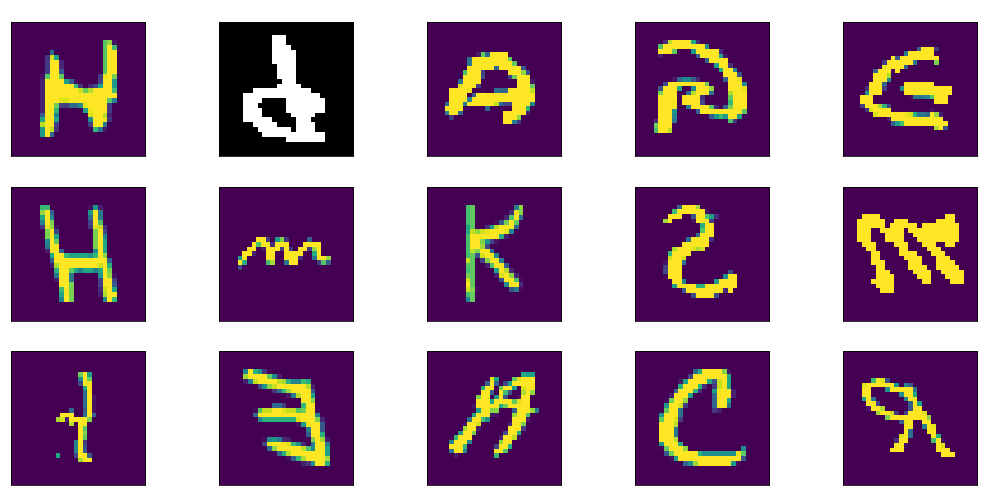

In [32]:
# display 20 picture of the dataset with their labels
from turtle import color

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i], color='white')
plt.tight_layout()
plt.show()

# Model

## Detection using EEG Scans

Neural Network

In [23]:
#Scaling the datasets
from sklearn.preprocessing import StandardScaler
scaler_eeg=StandardScaler()
scaler_eeg.fit(df_top)
df_sc=scaler_eeg.transform(df_top)

In [24]:
#Building the neural-network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks,layers

In [25]:
#Splitting it as Train and Test
from sklearn.model_selection import train_test_split
y=pd.get_dummies(df['user-definedlabeln'])
Xtr,xte,Ytr,yte=train_test_split(df_sc,y,random_state=42,test_size=0.27)
xtr,xval,ytr,yval=train_test_split(Xtr,Ytr,random_state=42,test_size=0.27)

In [26]:
model_eeg_nn=keras.Sequential([
    layers.Dense(64,input_shape=(14,),activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),   
    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2,activation='sigmoid')
])

model_eeg_nn.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')
model_eeg_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [27]:
history_model_eeg=model_eeg_nn.fit(xtr,ytr,validation_data=(xval,yval),batch_size=30,epochs=150)

Epoch 1/150
228/228 [==============================] - 10s 21ms/step - loss: 0.7889 - accuracy: 0.5820 - val_loss: 0.6301 - val_accuracy: 0.6679
Epoch 2/150
228/228 [==============================] - 5s 20ms/step - loss: 0.6903 - accuracy: 0.6135 - val_loss: 0.5993 - val_accuracy: 0.6857
Epoch 3/150
228/228 [==============================] - 4s 17ms/step - loss: 0.6535 - accuracy: 0.6408 - val_loss: 0.5847 - val_accuracy: 0.6956
Epoch 4/150
228/228 [==============================] - 4s 17ms/step - loss: 0.6260 - accuracy: 0.6620 - val_loss: 0.5688 - val_accuracy: 0.6975
Epoch 5/150
228/228 [==============================] - 4s 16ms/step - loss: 0.6193 - accuracy: 0.6644 - val_loss: 0.5600 - val_accuracy: 0.7189
Epoch 6/150
228/228 [==============================] - 4s 18ms/step - loss: 0.6116 - accuracy: 0.6765 - val_loss: 0.5540 - val_accuracy: 0.7138
Epoch 7/150
228/228 [==============================] - 4s 17ms/step - loss: 0.5949 - accuracy: 0.6912 - val_loss: 0.5395 - val_accuracy

In [28]:
#Testing the model
model_eeg_nn.evaluate(xte,yte)

109/109 [==============================] - 1s 6ms/step - loss: 0.0280 - accuracy: 0.9936


[0.02799062430858612, 0.9936397671699524]

In [29]:
pred=model_eeg_nn.predict(xte)
pred= [i[0] for i in pred]

109/109 [==============================] - 1s 4ms/step


In [30]:
df_pred = pd.DataFrame(zip(yte[0], pred), columns=['Actual','Pred'])
df_pred

,Actual,Pred
0,0,0.005042
1,1,0.999182
2,0,0.002009
3,1,0.567648
4,1,0.998385
...,...,...
3454,0,0.040078
3455,0,0.037901
3456,0,0.009397
3457,1,0.999589


In [31]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
print("Test data R2 score:", r2_score(yte[0],pred))

Test data R2 score: 0.9735008426446881


SVM

In [47]:
Y_2 = df.iloc[:,17].values
print(Y_2.shape)
X_2 = df_top.iloc[:,1:14].values
X_2.shape

(12811,)


(12811, 13)

In [48]:
#Splitting Dataset
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_2, Y_2,random_state=42,test_size=0.2)

In [49]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [50]:
from sklearn.svm import SVC
model_eeg_svm = SVC()
model_eeg_svm.fit(X_train, y_train)
y_pred_svc = model_eeg_svm.predict(X_test)
acc_svc = model_eeg_svm.score(X_test, y_test)
print("Accuracy is:",str(acc_svc))

Accuracy is: 0.9126024190401872


## Comparison between models

In [52]:
print("Accuracy of SVM is: ",str(acc_svc))
print("Accuracy of neural network is: ",model_eeg_nn.evaluate(xte,yte)[1])

Accuracy of SVM is:  0.9126024190401872
109/109 [==============================] - 1s 6ms/step - loss: 0.0280 - accuracy: 0.9936
Accuracy of neural network is:  0.9936397671699524


We notice that the better model for diagnosing dyslexia based on EEG signals is ANN

In [53]:
df_test=df_top.head(1)
df_test

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,age
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,25


In [54]:
df_sc_test=scaler_eeg.transform(df_test)

In [56]:
model_eeg_nn.predict(df_sc_test)

1/1 [==============================] - 0s 64ms/step


array([[0.9986517 , 0.00134836]], dtype=float32)

In [57]:
model_eeg_nn.save('Model/eeg', overwrite=True)

INFO:tensorflow:Assets written to: Model/eeg\assets


In [60]:
import joblib
joblib.dump(scaler_eeg, 'scaler_eeg.bin', compress=True)

['scaler_eeg.bin']

## Detection using Standardized Test

### SVM

In [52]:
X=data.drop(['Label'],axis='columns')
y=data.Label
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size= 0.2)
model_stdtest_svm=SVC(kernel='linear',C=1)

In [53]:
#Train the linear SVC classifier using the training data
model_stdtest_svm.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [54]:
svm_pred = model_stdtest_svm.predict(X_test)

In [55]:
accuracy = model_stdtest_svm.score(X_test, y_test)
accuracy

0.97

### Naive Bayes

In [56]:
X=data.drop(['Label'],axis='columns')
y=data.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [57]:
#Next, we are doing feature scaling to the training and test set of independent variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [58]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [59]:
from sklearn.naive_bayes import GaussianNB
model_stdtest_nb = GaussianNB()
model_stdtest_nb.fit(X_train, y_train)

GaussianNB()

In [60]:
y_pred  =  model_stdtest_nb.predict(X_test)
y_pred

array([1, 1, 2, 0, 2, 1, 1, 2, 0, 1, 1, 2, 0, 2, 0, 2, 2, 1, 1, 1, 2, 1,
       1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1,
       1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 0, 2, 2, 0], dtype=int64)

In [61]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 6,  0,  0],
       [ 2, 42, 18],
       [ 0,  0, 32]], dtype=int64)

In [62]:
ac = accuracy_score(y_test,y_pred)
ac

0.8

### Random Forest

In [63]:
X=data.drop(['Label'],axis='columns')
y=data.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [64]:
#Feature Scaling, not required since all are between range of 0 and 1 but doing it nonetheless
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [65]:
from sklearn.ensemble import RandomForestClassifier
model_stdtest_rf = RandomForestClassifier(n_estimators=20, random_state=0)
model_stdtest_rf.fit(X_train, y_train)
y_pred = model_stdtest_rf.predict(X_test)
Pred = model_stdtest_rf.predict(X_test)

In [66]:

from sklearn.metrics import classification_report
rand_score=model_stdtest_rf.score(X_test, y_test)
classification_report_rf=classification_report(y_test,Pred)
print("Accuracy score:",rand_score)

Accuracy score: 0.89


SVM has the best accuracy amoung the three method, hence we choose this to be our main model for prediction.

### Testing

In [68]:
from sklearn.metrics import mean_absolute_error
#Reading file without labels.
data=pd.read_csv('Dataset/Standardized_Test/unlabeled_dysx.csv')
#Labels of this file will be predicted by the prepared model.
data.head()

,Language_vocab,Memory,Speed,Visual_discrimination,Audio_Discrimination,Survey_Score
0,0.5,0.6,0.5,0.8,0.6,0.7
1,0.6,0.7,0.8,0.9,0.5,0.8
2,0.6,0.4,0.3,0.3,0.4,0.6
3,0.3,0.5,0.2,0.1,0.3,0.5
4,0.7,0.6,0.7,0.8,0.9,0.5


In [69]:
#Reading file with labels.
dataset = pd.read_csv('Dataset/Standardized_Test/labeled_dysx.csv')
#Predictions made for the above file will be compared with labels present in this file.
y_given = dataset.Label #The type of y_given is Pandas Series.
dataset.head()

,Language_vocab,Memory,Speed,Visual_discrimination,Audio_Discrimination,Survey_Score,Label
0,0.5,0.6,0.5,0.8,0.6,0.7,1
1,0.6,0.7,0.8,0.9,0.5,0.8,2
2,0.6,0.4,0.3,0.3,0.4,0.6,1
3,0.3,0.5,0.2,0.1,0.3,0.5,0
4,0.7,0.6,0.7,0.8,0.9,0.5,2


In [70]:
sc=StandardScaler(copy=False)
sc.fit_transform(data)

array([[-0.3900195 ,  0.13196981, -0.35675902,  1.00196844,  0.09803907,
         0.56539244],
       [ 0.1100055 ,  0.60329054,  1.03683089,  1.46285549, -0.39710776,
         1.04051214],
       [ 0.1100055 , -0.81067167, -1.28581896, -1.3024668 , -0.8922546 ,
         0.09027274],
       ...,
       [ 0.6100305 , -0.33935093,  1.03683089,  1.46285549,  1.08833274,
        -0.38484696],
       [-1.39006951, -0.33935093, -0.82128899,  0.08019435,  0.09803907,
         0.09027274],
       [ 0.6100305 ,  0.60329054,  1.03683089,  0.08019435,  1.08833274,
         0.09027274]])

In [71]:
y_pred = model_stdtest_svm.predict(data)
y_pred = pd.Series(y_pred)
y_pred.head()

0    0
1    1
2    0
3    0
4    1
dtype: int64

### Saving the Model

In [72]:
pickle.dump(model_stdtest_svm, open('Model/stdtest.pkl', 'wb'))

## Detection using Handwriting

### Neural Network

In [74]:
#Spliting Dataset into training set and testing set
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(r'Dataset/Gambo/Train/',
                                                 target_size = (29, 29),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 )

test_set = test_datagen.flow_from_directory(r'Dataset/Gambo/Test/',
                                            target_size = (29, 29),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            )

Found 151649 images belonging to 3 classes.
Found 56723 images belonging to 3 classes.


In [75]:
#CNN
model_handwriting = Sequential()
model_handwriting.add(Conv2D(512, (3, 3), input_shape = (29,29,3), activation = 'relu'))
model_handwriting.add(Conv2D(512, (3, 3), activation = 'relu'))
model_handwriting.add(MaxPooling2D(pool_size = (2, 2)))
model_handwriting.add(Conv2D(128, (3, 3), activation = 'relu'))
model_handwriting.add(Conv2D(128, (3, 3), activation = 'relu'))
model_handwriting.add(MaxPooling2D(pool_size = (2, 2)))
model_handwriting.add(Flatten())
model_handwriting.add(Dense(units = 128, activation = 'relu'))
model_handwriting.add(Dense(units = 64, activation = 'relu'))
model_handwriting.add(Dense(units = 3, activation = 'softmax'))
model_handwriting.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_handwriting.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 517)       14476     
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 512)       2382848   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 512)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       589952    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                  

In [76]:
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback

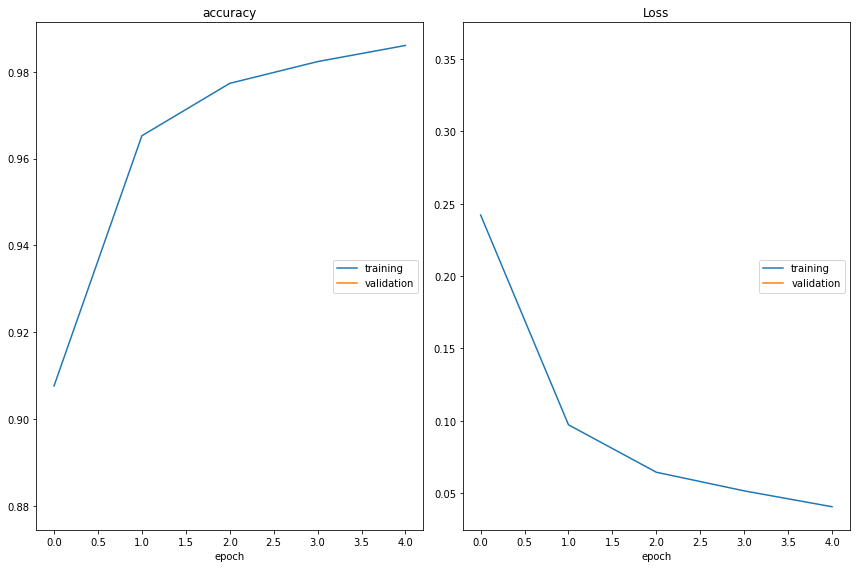

accuracy
	training         	 (min:    0.908, max:    0.986, cur:    0.986)
	validation       	 (min:    0.880, max:    0.880, cur:    0.880)
Loss
	training         	 (min:    0.041, max:    0.242, cur:    0.041)
	validation       	 (min:    0.359, max:    0.359, cur:    0.359)

Epoch 5: saving model to model_weights.h5
2000/2000 [==============================] - 175s 88ms/step - loss: 0.0407 - accuracy: 0.9861 - lr: 0.0010


In [77]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history_handwriting=model_handwriting.fit(training_set,
                         steps_per_epoch = 2000,
                         epochs = 5,
                         validation_data = test_set,
                         validation_steps = 2000,
                         callbacks=callbacks
                         )

In [80]:
model_handwriting.save('Model/handwriting', overwrite=True)

INFO:tensorflow:Assets written to: Model/handwriting\assets


INFO:tensorflow:Assets written to: Model/handwriting\assets
